

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
%%capture
%%bash
pip install -U torch torchvision kaggle==1.5.9 imagehash

In [2]:
%%capture
%%bash

gdown https://drive.google.com/uc?id=1wvBBnfl1OyL5Q99p3Qpz9zegZpq-UF_L
unzip journey-springfield.zip -d .

In [5]:
import glob2 as glob
import os
import pandas as pd
import numpy as np

In [12]:
r=[]
for f in glob.glob("/content/train/simpsons_dataset/*"):
  r.append({"person":os.path.basename(f), "count": len(glob.glob(f"{f}/*.jpg"))})
pd.DataFrame(r).sort_values(by="count")

,person,count
30,lionel_hutz,3
32,disco_stu,8
27,troy_mcclure,8
20,miss_hoover,17
29,fat_tony,27
15,gil,27
17,otto_mann,32
14,sideshow_mel,40
10,agnes_skinner,42
35,rainier_wolfcastle,45


In [14]:
import torch
import torchvision
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [15]:
import PIL
print(PIL.__version__)
print(torch.__version__)

7.0.0
1.7.0+cu101


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [16]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [17]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [18]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [19]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [20]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [21]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [22]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

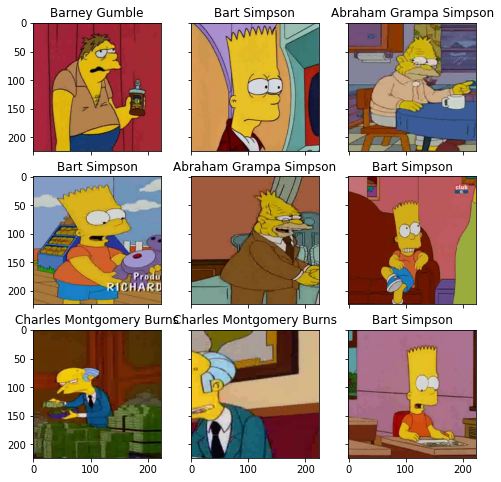

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
import torch
import torch.nn as nn


class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()


class ASLSingleLabel(nn.Module):
    def __init__(self, gamma_pos=0, gamma_neg=4, eps: float = 0.1, reduction='mean'):
        super(ASLSingleLabel, self).__init__()

        self.eps = eps
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.targets_classes = []  # prevent gpu repeated memory allocation
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.reduction = reduction

    def forward(self, inputs, target, reduction=None):
        num_classes = inputs.size()[-1]
        log_preds = self.logsoftmax(inputs)
        self.targets_classes = torch.zeros_like(inputs).scatter_(1, target.long().unsqueeze(1), 1)

        # ASL weights
        targets = self.targets_classes
        anti_targets = 1 - targets
        xs_pos = torch.exp(log_preds)
        xs_neg = 1 - xs_pos
        xs_pos = xs_pos * targets
        xs_neg = xs_neg * anti_targets
        asymmetric_w = torch.pow(1 - xs_pos - xs_neg,
                                 self.gamma_pos * targets + self.gamma_neg * anti_targets)
        log_preds = log_preds * asymmetric_w

        if self.eps > 0:  # label smoothing
            self.targets_classes.mul_(1 - self.eps).add_(self.eps / num_classes)

        # loss calculation
        loss = - self.targets_classes.mul(log_preds)

        loss = loss.sum(dim=-1)
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = AsymmetricLossOptimized() #nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [ ]:
from torchvision import models
resnet50 = models.resnet50(pretrained = True).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


уже натренировал модель на куче картинок, вкратце, поскольку вы видим большой мисбаланс, была натренирована обычная модель(ниже), проверены ошибки которые она делает по классам и затем...взяты ролики из ютуба (best moments of Willie, Simpsons) порезаны по картинкам ffmpeg , поиск по хэшу и некоторая ручная обработка и собраны картинки для недостающих персонажей

In [ ]:
# resnet50_2 = models.resnet50(pretrained = True).to(DEVICE)
resnet50_2 = torch.load('/content/drive/MyDrive/stepik/simpsons_pytorch/model.bin').to(DEVICE)
resnet50_2.eval()

опционально

In [ ]:
# ct = 0
# for child in resnet50.children():
#   ct += 1
#   if ct < 8:
#     for param in child.parameters():
#         param.requires_grad = False   
# resnet50.fc = nn.Linear(2048, 42).to(DEVICE) 

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=resnet50, epochs=10, batch_size=1)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss -66807.81182873041


epoch:  10%|█         | 1/10 [07:10<1:04:37, 430.83s/it]


Epoch 001 train_loss: -66807.8118     val_loss 10.3359 train_acc 0.0589 val_acc 0.0577
loss 10.400508073545529


epoch:  20%|██        | 2/10 [14:34<57:57, 434.64s/it]


Epoch 002 train_loss: 10.4005     val_loss 10.3359 train_acc 0.0576 val_acc 0.0577
loss 10.400508073545522


epoch:  30%|███       | 3/10 [21:34<50:11, 430.21s/it]


Epoch 003 train_loss: 10.4005     val_loss 10.3359 train_acc 0.0576 val_acc 0.0577
loss 10.40050807354552


epoch:  40%|████      | 4/10 [28:30<42:36, 426.09s/it]


Epoch 004 train_loss: 10.4005     val_loss 10.3359 train_acc 0.0576 val_acc 0.0577
loss 10.400508073545527


epoch:  50%|█████     | 5/10 [35:24<35:12, 422.44s/it]


Epoch 005 train_loss: 10.4005     val_loss 10.3359 train_acc 0.0576 val_acc 0.0577
loss 10.400508073545517


epoch:  60%|██████    | 6/10 [42:16<27:56, 419.16s/it]


Epoch 006 train_loss: 10.4005     val_loss 10.3359 train_acc 0.0576 val_acc 0.0577
loss 10.400508073545549


epoch:  70%|███████   | 7/10 [49:09<20:51, 417.32s/it]


Epoch 007 train_loss: 10.4005     val_loss 10.3359 train_acc 0.0576 val_acc 0.0577
loss 10.400508073545533


epoch:  80%|████████  | 8/10 [55:54<13:47, 413.82s/it]


Epoch 008 train_loss: 10.4005     val_loss 10.3359 train_acc 0.0576 val_acc 0.0577
loss 10.40050807354552


epoch:  90%|█████████ | 9/10 [1:02:52<06:55, 415.02s/it]


Epoch 009 train_loss: 10.4005     val_loss 10.3359 train_acc 0.0576 val_acc 0.0577
loss 10.40050807354552


epoch: 100%|██████████| 10/10 [1:09:57<00:00, 419.74s/it]


Epoch 010 train_loss: 10.4005     val_loss 10.3359 train_acc 0.0576 val_acc 0.0577


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

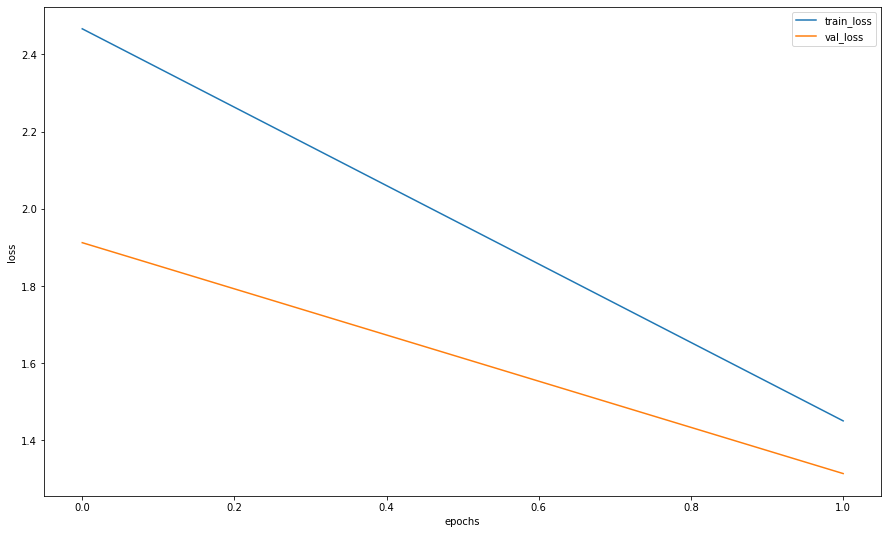

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet50, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet50, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


1.0

In [ ]:
y_pred!=actual_labels

array([ True,  True, False, False, False, False, False,  True, False,
       False,  True,  True, False,  True,  True, False,  True,  True,
       False, False])

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

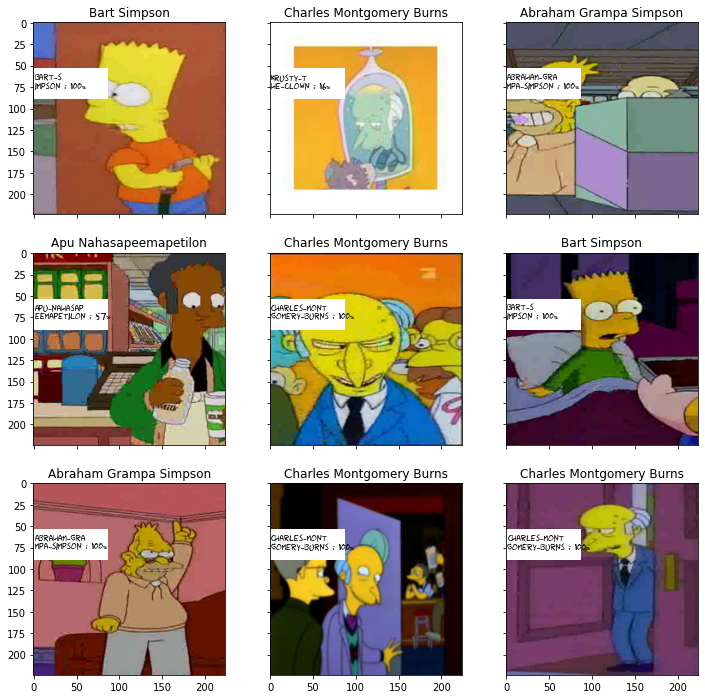

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet50, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
errors=[]
with torch.no_grad():
    for i in range(len(val_dataset)):
      im_val, label = val_dataset[i]
      img_label = " ".join(map(lambda x: x.capitalize(),\
                    val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
      prob_pred = predict_one_sample(resnet50, im_val.unsqueeze(0))
      predicted_proba = np.max(prob_pred)*100
      y_pred = np.argmax(prob_pred)
      predicted_label = label_encoder.classes_[y_pred]
      # predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
      predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

      
      if label!=y_pred:
        errors.append({"label":label, "y_pred":y_pred, "predicted_text":predicted_text, "predicted_label":predicted_label, "img_label":img_label})

In [ ]:
torch.save(resnet50, "/content/drive/MyDrive/stepik/simpsons_pytorch/model.bin")

In [ ]:
outs = pd.DataFrame(errors)
outs.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321
label,0,0,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,...,32,32,32,32,32,32,33,33,33,33,33,34,34,34,34,34,35,36,36,37,37,39,39,39,39,40,41,41,41,41,41,41,41,41,41,41,41,41,41,41
y_pred,15,15,27,30,30,27,27,27,5,15,15,17,16,0,0,0,0,0,15,27,0,4,0,27,0,22,15,7,25,22,34,22,22,22,22,15,22,15,22,30,...,15,27,22,27,27,30,15,0,32,17,17,15,16,16,16,27,0,27,27,15,15,15,7,24,27,16,27,27,27,27,27,27,6,27,27,27,27,27,27,27
predicted_text,homer_simpson : 65%,homer_simpson : 68%,moe_szyslak : 29%,otto_mann : 99%,otto_mann : 53%,moe_szyslak : 75%,moe_szyslak : 100%,moe_szyslak : 83%,carl_carlson : 46%,homer_simpson : 100%,homer_simpson : 100%,krusty_the_clown : 90%,kent_brockman : 100%,abraham_grampa_simpson : 67%,abraham_grampa_simpson : 85%,abraham_grampa_simpson : 58%,abraham_grampa_simpson : 100%,abraham_grampa_simpson : 99%,homer_simpson : 54%,moe_szyslak : 75%,abraham_grampa_simpson : 100%,bart_simpson : 100%,abraham_grampa_simpson : 87%,moe_szyslak : 90%,abraham_grampa_simpson : 76%,marge_simpson : 98%,homer_simpson : 86%,chief_wiggum : 100%,milhouse_van_houten : 88%,marge_simpson : 75%,rainier_wolfcastle : 79%,marge_simpson : 97%,marge_simpson : 40%,marge_simpson : 70%,marge_simpson : 93%,homer_simpson : 56%,marge_simpson : 80%,homer_simpson : 69%,marge_simpson : 100%,otto_mann : 76%,...,homer_simpson : 94%,moe_szyslak : 96%,marge_simpson : 22%,moe_szyslak : 50%,moe_szyslak : 91%,otto_mann : 35%,homer_simpson : 100%,abraham_grampa_simpson : 44%,principal_skinner : 99%,krusty_the_clown : 97%,krusty_the_clown : 87%,homer_simpson : 92%,kent_brockman : 100%,kent_brockman : 44%,kent_brockman : 98%,moe_szyslak : 58%,abraham_grampa_simpson : 51%,moe_szyslak : 64%,moe_szyslak : 100%,homer_simpson : 29%,homer_simpson : 32%,homer_simpson : 92%,chief_wiggum : 30%,mayor_quimby : 22%,moe_szyslak : 59%,kent_brockman : 100%,moe_szyslak : 78%,moe_szyslak : 100%,moe_szyslak : 98%,moe_szyslak : 92%,moe_szyslak : 82%,moe_szyslak : 57%,charles_montgomery_burns : 19%,moe_szyslak : 99%,moe_szyslak : 78%,moe_szyslak : 70%,moe_szyslak : 99%,moe_szyslak : 76%,moe_szyslak : 41%,moe_szyslak : 68%
predicted_label,homer_simpson,homer_simpson,moe_szyslak,otto_mann,otto_mann,moe_szyslak,moe_szyslak,moe_szyslak,carl_carlson,homer_simpson,homer_simpson,krusty_the_clown,kent_brockman,abraham_grampa_simpson,abraham_grampa_simpson,abraham_grampa_simpson,abraham_grampa_simpson,abraham_grampa_simpson,homer_simpson,moe_szyslak,abraham_grampa_simpson,bart_simpson,abraham_grampa_simpson,moe_szyslak,abraham_grampa_simpson,marge_simpson,homer_simpson,chief_wiggum,milhouse_van_houten,marge_simpson,rainier_wolfcastle,marge_simpson,marge_simpson,marge_simpson,marge_simpson,homer_simpson,marge_simpson,homer_simpson,marge_simpson,otto_mann,...,homer_simpson,moe_szyslak,marge_simpson,moe_szyslak,moe_szyslak,otto_mann,homer_simpson,abraham_grampa_simpson,principal_skinner,krusty_the_clown,krusty_the_clown,homer_simpson,kent_brockman,kent_brockman,kent_brockman,moe_szyslak,abraham_grampa_simpson,moe_szyslak,moe_szyslak,homer_simpson,homer_simpson,homer_simpson,chief_wiggum,mayor_quimby,moe_szyslak,kent_brockman,moe_szyslak,moe_szyslak,moe_szyslak,moe_szyslak,moe_szyslak,moe_szyslak,charles_montgomery_burns,moe_szyslak,moe_szyslak,moe_szyslak,moe_szyslak,moe_szyslak,moe_szyslak,moe_szyslak
img_label,Abraham Grampa Simpson,Abraham Grampa Simpson,Agnes Skinner,Apu Nahasapeemapetilon,Apu Nahasapeemapetilon,Apu Nahasapeemapetilon,Apu Nahasapeemapetilon,Apu Nahasapeemapetilon,Apu Nahasapeemapetilon,Apu Nahasapeemapetilon,Apu Nahasapeemapetilon,Apu Nahasapeemapetilon,Apu Nahasapeemapetilon,Barney Gumble,Barney Gumble,Barney Gumble,Barney Gumble,Barney Gumble,Barney Gumble,Barney Gumble,Barn

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


3 модель

In [24]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import glob2 as glob

In [26]:
d = dict()
for f in glob.glob("/content/train/simpsons_dataset/*"):
  d[os.path.basename(f)] = len(glob.glob(f"{f}/*.jpg"))
  
max_len = max(d.values())

In [27]:
def sample_images(folder, max_len):
  arr = np.array(glob.glob(f"{folder}/*.jpg"))
  return arr[np.random.choice(np.arange(len(arr)), max_len-len(arr))]

In [28]:
import shutil
import uuid

In [29]:
for f in glob.glob("/content/train/simpsons_dataset/*"):
  for img_f in sample_images(f, max_len):
    dst = os.path.join(os.path.dirname(img_f), str(uuid.uuid1())+".jpg")
    shutil.copy(img_f,dst)

In [30]:
d = dict()
for f in glob.glob("/content/train/simpsons_dataset/*"):
  d[os.path.basename(f)] = len(glob.glob(f"{f}/*.jpg"))
d

{'abraham_grampa_simpson': 2246,
 'agnes_skinner': 2246,
 'apu_nahasapeemapetilon': 2246,
 'barney_gumble': 2246,
 'bart_simpson': 2246,
 'carl_carlson': 2246,
 'charles_montgomery_burns': 2246,
 'chief_wiggum': 2246,
 'cletus_spuckler': 2246,
 'comic_book_guy': 2246,
 'disco_stu': 2246,
 'edna_krabappel': 2246,
 'fat_tony': 2246,
 'gil': 2246,
 'groundskeeper_willie': 2246,
 'homer_simpson': 2246,
 'kent_brockman': 2246,
 'krusty_the_clown': 2246,
 'lenny_leonard': 2246,
 'lionel_hutz': 2246,
 'lisa_simpson': 2246,
 'maggie_simpson': 2246,
 'marge_simpson': 2246,
 'martin_prince': 2246,
 'mayor_quimby': 2246,
 'milhouse_van_houten': 2246,
 'miss_hoover': 2246,
 'moe_szyslak': 2246,
 'ned_flanders': 2246,
 'nelson_muntz': 2246,
 'otto_mann': 2246,
 'patty_bouvier': 2246,
 'principal_skinner': 2246,
 'professor_john_frink': 2246,
 'rainier_wolfcastle': 2246,
 'ralph_wiggum': 2246,
 'selma_bouvier': 2246,
 'sideshow_bob': 2246,
 'sideshow_mel': 2246,
 'snake_jailbird': 2246,
 'troy_mcclu

In [34]:
train_data_dir = "/content/train/simpsons_dataset"
batch_size = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    batch_size=batch_size,
    shuffle = True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset='training') 
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    batch_size=batch_size,
    shuffle = True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset='validation') 

In [31]:
!pip install efficientnet

     |████████████████████████████████| 51kB 2.8MB/s 


In [32]:
import efficientnet.keras as efn

In [35]:
efficient_net = efn.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    )


16809984/16804768 [==============================] - 0s 0us/step


In [ ]:
efficient_net = tf.keras.applications.MobileNetV2(input_shape=[224,224, 3], include_top=False)
    #pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
    #pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    # EfficientNet can be loaded through efficientnet.tfkeras library (https://github.com/qubvel/efficientnet)
    #pretrained_model = efficientnet.tfkeras.EfficientNetB0(weights='imagenet', include_top=False)
efficient_net.trainable = True

In [ ]:
model = tf.keras.Sequential([
  efficient_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(640,kernel_regularizer=keras.regularizers.l2(0.001), activation = 'relu'), ##
  # tf.keras.layers.ReLU(max_value=6),
  tf.keras.layers.Dropout(.4),
  tf.keras.layers.Dense(240,kernel_regularizer=keras.regularizers.l2(0.001), activation = 'relu'), ##
  # tf.keras.layers.ReLU(max_value=6),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(42, activation = 'softmax')])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
history = model.fit(
    train_generator,
    # steps_per_epoch=total_train // batch_size,
    epochs=20,
    validation_data=validation_generator,
    # validation_steps=total_val // batch_size
)

Epoch 1/20
2372/2372 [==============================] - 1217s 513ms/step - loss: 1.7970 - categorical_accuracy: 0.2924 - val_loss: 2.9201 - val_categorical_accuracy: 0.5396
Epoch 2/20
2372/2372 [==============================] - 1233s 520ms/step - loss: 1.3061 - categorical_accuracy: 0.4032 - val_loss: 2.7873 - val_categorical_accuracy: 0.5788
Epoch 3/20
2372/2372 [==============================] - 1204s 508ms/step - loss: 1.2161 - categorical_accuracy: 0.5261 - val_loss: 2.7249 - val_categorical_accuracy: 0.6893
Epoch 4/20
2372/2372 [==============================] - 1168s 492ms/step - loss: 1.1623 - categorical_accuracy: 0.5396 - val_loss: 2.6794 - val_categorical_accuracy: 0.6149
Epoch 5/20
2372/2372 [==============================] - 1214s 512ms/step - loss: 1.1254 - categorical_accuracy: 0.6484 - val_loss: 2.6408 - val_categorical_accuracy: 0.6151
Epoch 6/20
2372/2372 [==============================] - 1241s 523ms/step - loss: 1.1015 - categorical_accuracy: 0.7048 - val_loss: 2.61

In [ ]:
model.save("/content/drive/MyDrive/stepik/tf")

In [ ]:
path_to_data = "/content/train/simpsons_dataset"
labels_name = os.listdir(path_to_data)
labels_name.sort()
index_name = [i for i in range(0,len(labels_name))]
labels_dict = dict(zip(index_name, labels_name))

In [ ]:
def index_to_label(model, img_data_dir):
  image = tf.keras.preprocessing.image.load_img(img_data_dir,target_size = (IMG_HEIGHT, IMG_WIDTH))
  input_arr = keras.preprocessing.image.img_to_array(image)
  input_arr = tf.keras.applications.mobilenet_v2.preprocess_input(input_arr)
  input_arr = tf.reshape(input_arr , [1, 224, 224, 3])
  input = model(input_arr).numpy()
  predict = labels_dict[int(np.argmax(input, axis = 1))]
  return predict

In [ ]:
index_to_label(model,"/content/testset/testset/img101.jpg")

submit

In [ ]:
path_to_data = "/content/testset/testset"
test_names = os.listdir(path_to_data)
test_names = test_names

In [ ]:
preds = []
for image_test in test_names:
  predict = index_to_label(model,f"{path_to_data}/{image_test}")
  preds.append(predict)

In [ ]:
submit = pd.DataFrame(columns=['Id'])
submit['Id'] = test_names
submit[f'Expected'] = preds

In [ ]:
submit.to_csv("submit.csv", index=False)

Итог, было сделано несколько моделей, (всего 3) и сделан простой "блендинг", даже не ансамбль(поскольку я взял pytorch и tf модели, вместе они не тренируются), - правильным результатом считался по сути голосование, в случае несовпадения всех лейблов, результат натренированного на доп картинках resnet.  

Результат обычного реснет - 92% ,удалось повысить разбавлением доп моделями

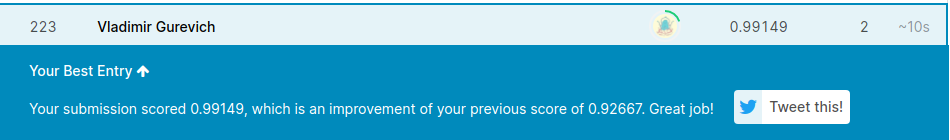

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
